In [7]:
import torch
from datasets import IndexedDataset, WeightedDataset
from torch.utils.data import DataLoader, DistributedSampler

from utils import get_args
from architectures import load_architecture

from samplers import DistributedCustomSampler
from losses import trades_loss
from tqdm.notebook import tqdm
from architectures import load_architecture, load_statedict, add_lora

args = get_args()
args.arch = 'LeNet5'
args.dataset = 'MNIST'
args.selection_method = 'none'

# Example Usage

model, target_layers = load_architecture(args)
model.to('cuda')

# statedict = load_statedict(args)
# model.load_state_dict(statedict)
# add_lora(target_layers, model)

args.pruning_ratio = 0
args.delta = 1
args.batch_size = 128
args.pruning_strategy = 'random'
args.batch_strategy = 'random'
args.sample_size= 128

# train_dataset = IndexedDataset()
print('init weighted dataset')
train_dataset = WeightedDataset(args, train=True, prune_ratio = args.pruning_ratio,  )

train_sampler = DistributedCustomSampler(args, train_dataset, num_replicas=1, rank=0, drop_last=True)

print('init dataloder')
trainloader = DataLoader(train_dataset, batch_size=None, sampler = train_sampler,) 

./data
init weighted dataset
60000 60000
init dataloder


In [8]:
from losses import get_loss, get_eval_loss

iterations = 10
rank = 'cuda'

optimizer = torch.optim.SGD( model.parameters(),lr=args.init_lr, weight_decay=args.weight_decay, momentum=args.momentum, nesterov=True, )

for iteration in range(iterations):

    model.train()
    train_sampler.set_epoch(iteration)

    for batch_id, batch in tqdm(enumerate( trainloader ) ):

        optimizer.zero_grad()

        data, target, idxs = batch

        data, target = data.to(rank), target.to(rank) 
         
        loss_values, clean_values, robust_values, logits_nat, logits_adv = get_loss(args, model, data, target, optimizer)

        assert torch.isfinite(loss_values).all(), "Loss contains NaNs!"
        assert torch.isfinite(logits_nat).all(), "Logits_nat contains NaNs!"
        assert torch.isfinite(logits_adv).all(), "Logits_adv contains NaNs!"

        train_dataset.update_scores2(iteration, idxs,loss_values)
        # train_dataset.update_scores(idxs, clean_values, robust_values, loss_values, logits_nat, logits_adv)
        loss = train_dataset.compute_loss(idxs, loss_values)

        loss.backward()
        optimizer.step()

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

pruning
remove tail


0it [00:00, ?it/s]

In [9]:
train_dataset.global_scores2

tensor([[2.3237e+00, 2.3809e+00, 2.2429e+00,  ..., 2.6965e-03, 1.6817e-02,
         1.5200e-02],
        [2.5047e-02, 6.1448e-03, 1.0331e-02,  ..., 5.0764e-05, 4.9970e-04,
         7.5130e-04],
        [4.6232e-02, 2.2086e-04, 2.3690e-03,  ..., 2.0994e-04, 3.3754e-04,
         7.0520e-04],
        ...,
        [1.1053e-02, 5.9595e-07, 3.5586e-05,  ..., 4.2837e-06, 1.0644e-05,
         1.1198e-05],
        [2.3361e-02, 4.7676e-07, 4.7786e-05,  ..., 8.2002e-06, 6.3057e-06,
         9.0064e-06],
        [5.4487e-02, 3.5761e-07, 3.4758e-05,  ..., 5.5845e-06, 3.6929e-06,
         3.3195e-06]])

  0%|          | 0/60000 [00:00<?, ?it/s]

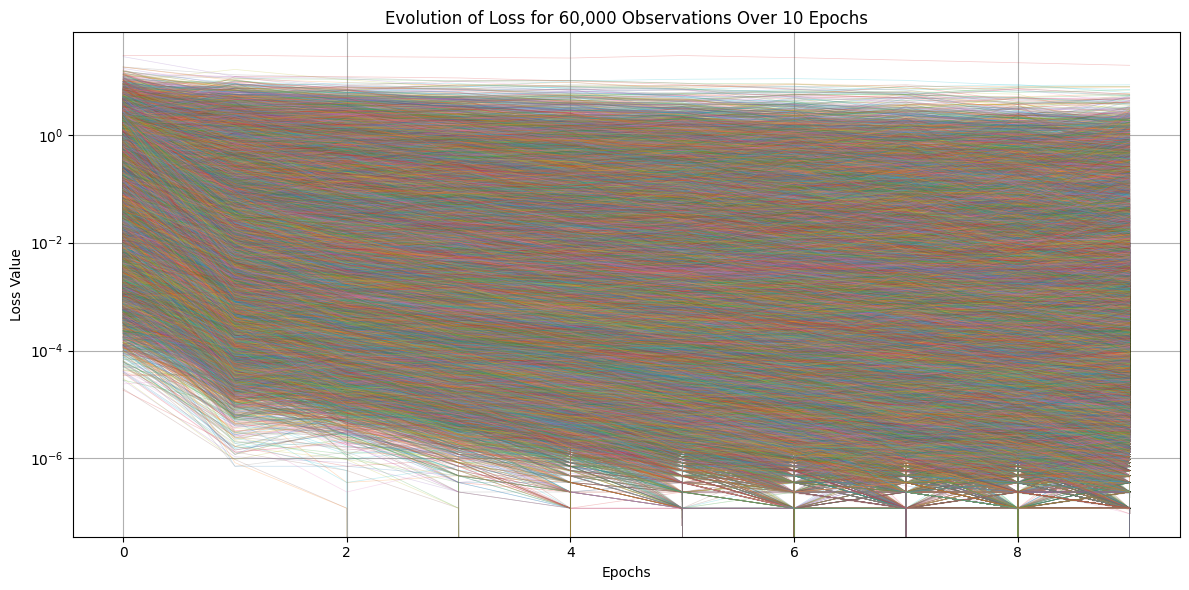

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a sample tensor with dimensions (10, 60000)
# Each of the 10 rows represents an epoch, and each column represents a loss value for one of the 60,000 observations.
np.random.seed(0)  # For reproducibility
tensor = train_dataset.global_scores2 #np.random.rand(10, 60000)  # Simulating loss values

# Sampling 1000 observations from the 60,000

sample_indices = np.random.choice(tensor.shape[1], size=60000, replace=False)

sampled_tensor = tensor[:, sample_indices]

# Plotting the evolution of the loss for the 60,000 observations over 10 epochs
plt.figure(figsize=(12, 6))

# Plotting each observation's loss over the 10 epochs
for i in tqdm(range(sampled_tensor.shape[1])):
    plt.plot(range(10), sampled_tensor[:, i], alpha=0.25, linewidth=0.5)  # Plotting with low opacity and thin lines for clarity

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.yscale('log')  # Setting y-axis to log scale

plt.title('Evolution of Loss for 60,000 Observations Over 10 Epochs')
plt.grid(True)
plt.tight_layout()

plt.show()


In [13]:
tensor

tensor([[0.0000, 2.3134, 0.0000,  ..., 2.2835, 0.0000, 2.2799],
        [0.0000, 2.3134, 0.0000,  ..., 2.2835, 0.0000, 2.2799],
        [0.0000, 2.3134, 0.0000,  ..., 2.2835, 0.0000, 2.2799],
        ...,
        [0.0000, 2.3134, 0.0000,  ..., 2.2835, 0.0000, 2.2799],
        [0.0000, 2.3134, 0.0000,  ..., 2.2835, 0.0000, 2.2799],
        [0.0000, 2.3134, 0.0000,  ..., 2.2835, 0.0000, 2.2799]])

In [ ]:

# for i in range(len(train_dataset)):
#     print(train_dataset[i])
import numpy as np

def obtain_latent_dataset(model, dataset, batch_size=32):

    # Assuming the dataset is a list or similar iterable with a known length
    num_samples = len(dataset)

    # Assume the dimensionality of the latent representation can be determined from one sample
    image,label, idx = dataset[0]
    image = torch.Tensor(image).to('cuda').unsqueeze(0)
    print(image.shape)
    first_latent_rep = model.get_latent_representation(image)
    latent_dim = first_latent_rep.shape[1]
    print(first_latent_rep.shape)
        
    # Preallocate the array for the latent representations
    latent_dataset = torch.zeros((num_samples, latent_dim))


    for i in tqdm( range(0, num_samples, batch_size) ):
        # Get the current batch of data
        batch_indices = list(range(i, min(i + batch_size, num_samples)))
        images,labels,idxs = dataset[batch_indices]
        images = images.to('cuda')
            
        # Process the batch to get latent representations
        batch_latent_reps = model.get_latent_representation(images) 
            
        # Store the results in the preallocated array
        latent_dataset[i:i + batch_size] = batch_latent_reps.detach().cpu()

    return latent_dataset

features =  obtain_latent_dataset(model,train_dataset,64)
train_dataset.define_latent_features(features)

